In [59]:
from typing import Tuple
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.utils.data import dataset
from torch.nn.utils.rnn import pad_sequence
import random
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
from torchtext.data.metrics import bleu_score

In [12]:
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

In [13]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
DEVICE = torch.device(device)
DEVICE


device(type='cpu')

In [14]:
data_path = 'swe.txt'

In [15]:
num_samples = 7000 
input_texts = []
target_texts = []

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.readlines()  

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.strip().split("\t")  
    input_texts.append(input_text) 
    target_texts.append(target_text)  

print(input_texts)
print(target_texts)

with open("all_texts.txt", "w", encoding='utf-8') as f:
    for input_text, target_text in zip(input_texts, target_texts):
        f.write(input_text + '\n')
        f.write(target_text + '\n')

['Go.', 'Run!', 'Run.', 'Who?', 'Duck!', 'Help!', 'Hide.', 'Jump!', 'Jump.', 'Stop!', 'Wait!', 'Wait.', 'Hello!', 'Hurry!', 'Hurry!', 'Hurry!', 'I ran.', 'I see.', 'I see.', 'I won!', 'Relax.', 'Shoot!', 'Smile.', 'Sorry?', 'Attack!', 'Cheers!', 'He ran.', 'Hug me.', 'I care.', 'I fell.', 'I knit.', 'I sang.', 'I swim.', 'No way!', 'Really?', 'Really?', 'Thanks!', 'Thanks.', 'We try.', 'Ask Tom.', 'Awesome!', 'Be cool.', 'Be kind.', 'Be kind.', 'Be nice.', 'Come in.', 'Come on.', 'Drop it!', 'Get Tom.', 'Get out!', 'Get out!', 'Go away!', 'Go away.', 'He runs.', 'Help me.', 'Hug Tom.', 'I agree.', 'I agree.', 'I cried.', 'I swore.', 'I tried.', 'I waved.', "It's OK.", 'Kiss me.', 'Me, too.', 'Perfect!', 'See you.', 'Show me.', 'Shut up!', 'Stop it.', 'Tell me.', 'Wake up!', 'Wash up.', 'We lost.', 'Back off!', 'Back off!', 'Be still.', 'Be still.', 'Can I go?', 'Cheer up!', 'Cheer up!', 'Drive on.', 'Find Tom.', 'Fix this.', 'Fix this.', 'Get away!', 'Get away!', 'Get away!', 'Get down

In [16]:
print(input_texts[500])

print(target_texts[500])

Is Tom mad?
Är Tom arg?


In [17]:
TRAIN_PERCENTAGE = 0.8
train_val = int(TRAIN_PERCENTAGE * num_samples)
train_val

5600

In [18]:
text_pairs = list(zip(input_texts, target_texts))
random.shuffle(text_pairs)
input_texts, target_texts = zip(*text_pairs)
input_texts, target_texts = list(input_texts), list(target_texts)

In [19]:
train_input_texts = input_texts[:train_val]
train_target_texts = target_texts[:train_val]

val_input_texts = input_texts[train_val:]
val_target_texts = target_texts[train_val:]

In [20]:
spm.SentencePieceTrainer.train('--input=all_texts.txt --model_prefix=m --vocab_size=13000 --model_type=bpe --pad_id=3')

# makes segmenter instance and loads the model file (m.model)
sp = spm.SentencePieceProcessor()
sp.load('m.model')

sp.SetEncodeExtraOptions("bos:eos")
sp.SetDecodeExtraOptions("bos:eos")

True

In [21]:
UNK_IDX, BOS_IDX, EOS_IDX,  PAD_IDX= 0, 1, 2, 3

In [22]:
def text2codes(texts, sp):
    codes = []
    for text in texts:
        code = sp.encode_as_ids(text)
        codes.append(torch.tensor(code))

    return codes

In [23]:
train_input_texts[:3], train_target_texts[:3]

(['What have we got?', 'Come back.', "I'm beautiful."],
 ['Vad har vi?', 'Kom tillbaka!', 'Jag är vacker.'])

In [24]:
text2codes(train_input_texts, sp)[:3]

[tensor([    1,   173,   170,   183,   262, 12963,     2]),
 tensor([    1,   471,   504, 12948,     2]),
 tensor([    1,    10, 12970, 12953,  5421, 12948,     2])]

In [25]:
text2codes(train_target_texts, sp)[:3]

[tensor([    1,   191,   105,   221, 12963,     2]),
 tensor([    1,   329,   615, 12982,     2]),
 tensor([    1,    22,    24,  5113, 12948,     2])]

In [26]:
def codes2text(codes, sp):
    texts = []
    for code in codes:
        text = sp.decode_ids(code.tolist())
        texts.append(text)
    return texts

In [27]:
codes2text(text2codes(train_input_texts, sp)[:3], sp)

['What have we got?', 'Come back.', "I'm beautiful."]

In [28]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)
                        * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
        self.emb_size = emb_size

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding * math.sqrt(self.emb_size)
                            + self.pos_embedding[:token_embedding.size(0), :])

In [29]:
pe = PositionalEncoding(10, 0.1)

In [30]:
torch.zeros(1, 5, 10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [31]:
pe(torch.zeros(1, 5, 10))

tensor([[[0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 0.0000],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 0.0000, 0.0000, 1.1111,
          0.0000, 1.1111],
         [0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111, 0.0000, 1.1111,
          0.0000, 1.1111]]])

In [32]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super().__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)

        self.emb_size = emb_size
        # Same source and target embs Sect. 3.4
        self.embedding = nn.Embedding(
            vocab_size, emb_size, padding_idx=PAD_IDX)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        # Bias to be compatible with embeddings
        self.generator = nn.Linear(emb_size, vocab_size, bias=False)
        self.generator.weight = self.embedding.weight  # Shared weights Sect. 3.4

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.embedding(src))
        tgt_emb = self.positional_encoding(self.embedding(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
            self.embedding(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
            self.embedding(tgt)), memory,
            tgt_mask)


In [33]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float(
        '-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [34]:
generate_square_subsequent_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [35]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),
                           device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1).type(torch.float32)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [36]:
src = pad_sequence(text2codes(
    train_input_texts[:3], sp), padding_value=PAD_IDX)
tgt = pad_sequence(text2codes(
    train_target_texts[:3], sp), padding_value=PAD_IDX)

In [37]:
train_input_texts[:3], train_target_texts[:3]

(['What have we got?', 'Come back.', "I'm beautiful."],
 ['Vad har vi?', 'Kom tillbaka!', 'Jag är vacker.'])

In [38]:
src

tensor([[    1,     1,     1],
        [  173,   471,    10],
        [  170,   504, 12970],
        [  183, 12948, 12953],
        [  262,     2,  5421],
        [12963,     3, 12948],
        [    2,     3,     2]])

In [39]:
tgt

tensor([[    1,     1,     1],
        [  191,   329,    22],
        [  105,   615,    24],
        [  221, 12982,  5113],
        [12963,     2, 12948],
        [    2,     3,     2]])

In [40]:
create_mask(src, tgt)

(tensor([[False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False]]),
 tensor([[0., -inf, -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf, -inf],
         [0., 0., 0., 0., -inf, -inf],
         [0., 0., 0., 0., 0., -inf],
         [0., 0., 0., 0., 0., 0.]]),
 tensor([[False, False, False, False, False, False, False],
         [False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False]]),
 tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.]]))

In [41]:
VOCAB_SIZE = 13000
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

In [42]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [43]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1) #SMOOTHING

optimizer = torch.optim.Adam(
            transformer.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9 #vilken learning rate behövs??
        )
lr_scheduler = LambdaLR( 
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=transformer.emb_size, factor=1.0, warmup=4000
        ),
    )#lagt till!!

/Users/alicetottie/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [44]:
class PairDataset(Dataset):
    def __init__(self, input_texts, target_texts, token2idx):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.token2idx = token2idx

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        src_batch = text2codes([input_texts[idx]], self.token2idx)
        tgt_batch = text2codes([target_texts[idx]], self.token2idx)

        return src_batch[0], tgt_batch[0]

    def collate(self, batch):
        src_batch, tgt_batch = list(zip(*batch))
        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

        return src_batch, tgt_batch

In [45]:
train_dataset = PairDataset(train_input_texts, train_target_texts, sp)
train_dataloader = DataLoader(train_dataset, batch_size=32,
                              shuffle=True, collate_fn=train_dataset.collate)

In [46]:
val_dataset = PairDataset(val_input_texts, val_target_texts, sp)
val_dataloader = DataLoader(
    val_dataset, batch_size=32, collate_fn=val_dataset.collate)

In [47]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0
    for src_batch, tgt_batch in tqdm(dataloader):
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src,
                       tgt_input,
                       src_mask,
                       tgt_mask,
                       src_padding_mask,
                       tgt_padding_mask,
                       src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        lr_scheduler.step() #LAGT TILL

        losses += loss.item()

        with torch.no_grad():
            sent_cnt += tgt_out.size()[-1]

            total += torch.numel(tgt_input)
            _, char_pred = torch.max(logits, -1)
            correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total

In [48]:
def evaluate(model, dataloader):
    model.eval()
    losses = 0
    sent_cnt = 0
    correct, total = 0, 0

    for src_batch, tgt_batch in dataloader:
        src = src_batch.to(DEVICE)
        tgt = tgt_batch.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
            src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,
                       src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(
            logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        sent_cnt += tgt_out.size()[-1]

        total += torch.numel(tgt_input)
        _, char_pred = torch.max(logits, -1)
        correct += (char_pred == tgt_out).sum().item()

    return losses / sent_cnt, correct / total

In [49]:
from timeit import default_timer as timer
NUM_EPOCHS = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss, train_acc = train_epoch(
        transformer, optimizer, train_dataloader)
    train_losses += [train_loss]
    train_accs += [train_acc]
    end_time = timer()
    val_loss, val_acc = evaluate(transformer, val_dataloader)
    val_losses += [val_loss]
    val_accs += [val_acc]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc.: {train_acc:.3f}, Val acc.: {val_acc:.3f}, Epoch time = {(end_time - start_time):.3f}s"))


100%|██████████| 175/175 [00:56<00:00,  3.12it/s]


Epoch: 1, Train loss: 0.256, Val loss: 0.215, Train acc.: 0.108, Val acc.: 0.123, Epoch time = 56.198s


100%|██████████| 175/175 [00:53<00:00,  3.27it/s]


Epoch: 2, Train loss: 0.176, Val loss: 0.149, Train acc.: 0.237, Val acc.: 0.305, Epoch time = 53.562s


100%|██████████| 175/175 [00:55<00:00,  3.13it/s]


Epoch: 3, Train loss: 0.140, Val loss: 0.131, Train acc.: 0.332, Val acc.: 0.353, Epoch time = 55.914s


100%|██████████| 175/175 [00:53<00:00,  3.27it/s]


Epoch: 4, Train loss: 0.128, Val loss: 0.121, Train acc.: 0.368, Val acc.: 0.386, Epoch time = 53.548s


100%|██████████| 175/175 [00:54<00:00,  3.24it/s]


Epoch: 5, Train loss: 0.119, Val loss: 0.113, Train acc.: 0.393, Val acc.: 0.406, Epoch time = 54.051s


100%|██████████| 175/175 [00:57<00:00,  3.03it/s]


Epoch: 6, Train loss: 0.113, Val loss: 0.106, Train acc.: 0.410, Val acc.: 0.421, Epoch time = 57.682s


100%|██████████| 175/175 [00:57<00:00,  3.05it/s]


Epoch: 7, Train loss: 0.108, Val loss: 0.104, Train acc.: 0.419, Val acc.: 0.427, Epoch time = 57.384s


100%|██████████| 175/175 [00:54<00:00,  3.19it/s]


Epoch: 8, Train loss: 0.103, Val loss: 0.097, Train acc.: 0.437, Val acc.: 0.447, Epoch time = 54.866s


100%|██████████| 175/175 [00:56<00:00,  3.10it/s]


Epoch: 9, Train loss: 0.099, Val loss: 0.092, Train acc.: 0.441, Val acc.: 0.454, Epoch time = 56.424s


100%|██████████| 175/175 [00:53<00:00,  3.26it/s]


Epoch: 10, Train loss: 0.095, Val loss: 0.088, Train acc.: 0.451, Val acc.: 0.462, Epoch time = 53.671s


100%|██████████| 175/175 [00:54<00:00,  3.23it/s]


Epoch: 11, Train loss: 0.092, Val loss: 0.086, Train acc.: 0.458, Val acc.: 0.466, Epoch time = 54.210s


100%|██████████| 175/175 [00:54<00:00,  3.19it/s]


Epoch: 12, Train loss: 0.089, Val loss: 0.082, Train acc.: 0.463, Val acc.: 0.483, Epoch time = 54.873s


100%|██████████| 175/175 [00:53<00:00,  3.27it/s]


Epoch: 13, Train loss: 0.087, Val loss: 0.080, Train acc.: 0.469, Val acc.: 0.486, Epoch time = 53.584s


100%|██████████| 175/175 [00:53<00:00,  3.27it/s]


Epoch: 14, Train loss: 0.085, Val loss: 0.077, Train acc.: 0.473, Val acc.: 0.497, Epoch time = 53.442s


100%|██████████| 175/175 [00:53<00:00,  3.26it/s]


Epoch: 15, Train loss: 0.083, Val loss: 0.076, Train acc.: 0.477, Val acc.: 0.503, Epoch time = 53.727s


In [50]:
epochs = range(NUM_EPOCHS)

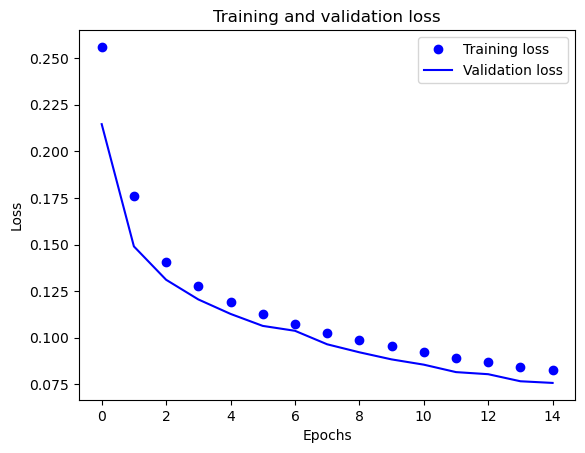

In [51]:
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

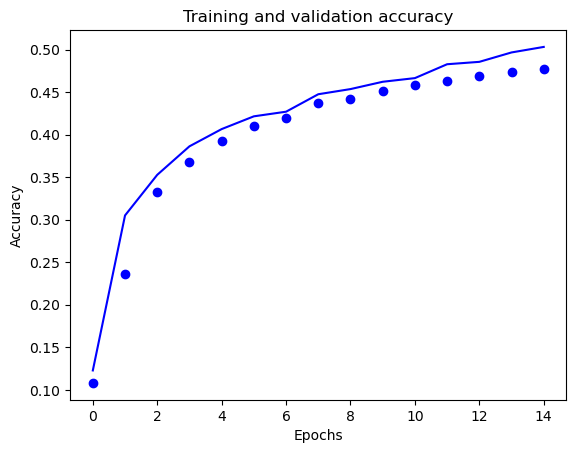

In [52]:
plt.plot(epochs, train_accs, 'bo', label='Training acc')
plt.plot(epochs, val_accs, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [61]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # print(ys) # Remove the comment to understand the loop
        #print(next_word)
        if next_word == EOS_IDX:
            
            break
    return ys

In [62]:
text2codes(['Go!'], sp)[0].view(-1, 1)

tensor([[    1],
        [  418],
        [12982],
        [    2]])

In [63]:
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text2codes([src_sentence], sp)[0].view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 20, start_symbol=BOS_IDX).flatten()
    tgt_chars_specials = codes2text([tgt_tokens], sp)
    tgt_words = []
    for token in tgt_chars_specials:
        if token not in ['<s>', '</s>', '<unk>']:
            tgt_words.append(token.strip())
    tgt_sentence = ' '.join(tgt_words)
    return tgt_sentence

In [64]:
tgt_sent = translate(transformer, 'I drink water every day')
tgt_sent

'Jag har varje dag.'

In [65]:
tgt_sent = translate(
    transformer, "Eine Gruppe von Menschen steht vor einem Iglu .")
tgt_sent

'Det är synd.'

In [72]:
eng = ["I live in a big red house.", "The sun is very big and hot.", "Today it's very cold and windy!", "Would you like to have some salt for your pasta?", "You need glasses, beacause you can't see.", "My dog is eigth years old.", "I'm wearing pants and a shirt.", "It is a fire in the building!", "Do you like to study on your computer?", "The bus was very full today."]
swe = ["Jag bor i ett stort rött hus.".split(), "Solen är väldigt stor och varm.".split(), "Idag är det väldigt kallt och blåsigt!".split(), "Vill du ha salt till din pasta?".split(), "Du behöver glasögon, för du kan inte se.".split(), "Min hund är är åtta år gammal.".split(), "Jag har på mig byxor och en tröja.".split(), "Det är en eld i byggnaden!".split(), "Gillar du att plugga på din dator?".split(), "Bussen var väldigt full idag.".split()]
cand = []
for sent in eng:
    cand.append(translate(transformer, sent))

#cand = ['Jag har varje dag']
#swe = ['Jag dricker vatten varje dag'.split()]
print(bleu_score(cand, swe))

0.32406944036483765
